In [1]:
from beattrack.model import BeatTCN
import torchaudio
from torchaudio.transforms import MelSpectrogram
from pathlib import Path
from IPython.display import Audio
import librosa
from einops import rearrange
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from madmom.features import DBNBeatTrackingProcessor
import librosa.display
from cfg import spec, sample_rate, data_length

/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mel_spec = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=spec["n_fft"],
    hop_length=spec["hop_size"],
    win_length=spec["win_length"],
    n_mels=spec["n_mels"],
)
def preprocess(audio_path):
    audio, sr = torchaudio.load(audio_path)
    resample = torchaudio.transforms.Resample(
            orig_freq=sr, new_freq=sample_rate
    )
    audio = resample(audio)
    data_length = 30 * sample_rate  # 30 seconds of audio
    
    # Pad or trim to 30 seconds
    if audio.shape[1] < data_length:
        audio = F.pad(audio, (0, data_length - audio.shape[1]))
    else:
        audio = audio[:, :data_length]
    mel = mel_spec(audio)
    channels, bins, frames = mel.shape
    mel = rearrange(mel, "c b f -> f (b c)")
    return mel


In [13]:
model = BeatTCN.load_from_checkpoint("checkpoints/best.ckpt")
model = model.eval()

beat_dbn = DBNBeatTrackingProcessor(min_bpm=55, max_bpm=215, transition_labmda = 100, fps=100)
downbeat_dbn = DBNBeatTrackingProcessor(min_bpm=15, max_bpm=80, transition_labmda = 100, fps=100)


In [7]:
# Pick a few files to test
files = []
root = Path("data/")
audio_root = root / "BallroomData"
for folder in audio_root.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.suffix == ".wav":
                files.append(file)

In [8]:
print(files)

[PosixPath('data/BallroomData/Waltz/Media-105901.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-04.wav'), PosixPath('data/BallroomData/Waltz/Media-104202.wav'), PosixPath('data/BallroomData/Waltz/Media-104203.wav'), PosixPath('data/BallroomData/Waltz/Media-105902.wav'), PosixPath('data/BallroomData/Waltz/Media-104201.wav'), PosixPath('data/BallroomData/Waltz/Media-104604.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-02.wav'), PosixPath('data/BallroomData/Waltz/Media-104402.wav'), PosixPath('data/BallroomData/Waltz/Media-104204.wav'), PosixPath('data/BallroomData/Waltz/Media-104205.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-03.wav'), PosixPath('data/BallroomData/Waltz/Media-104403.wav'), PosixPath('data/BallroomData/Waltz/Media-104601.wav'), PosixPath('data/BallroomData/Waltz/Media-104603.wav'), PosixPath('data/BallroomData/Waltz/Media-104401.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-01.wav'), PosixPath('data/Ballroom

In [9]:
test = files[0]
mel = preprocess(test)

torch.Size([1, 81, 3001])
torch.Size([3001, 81])


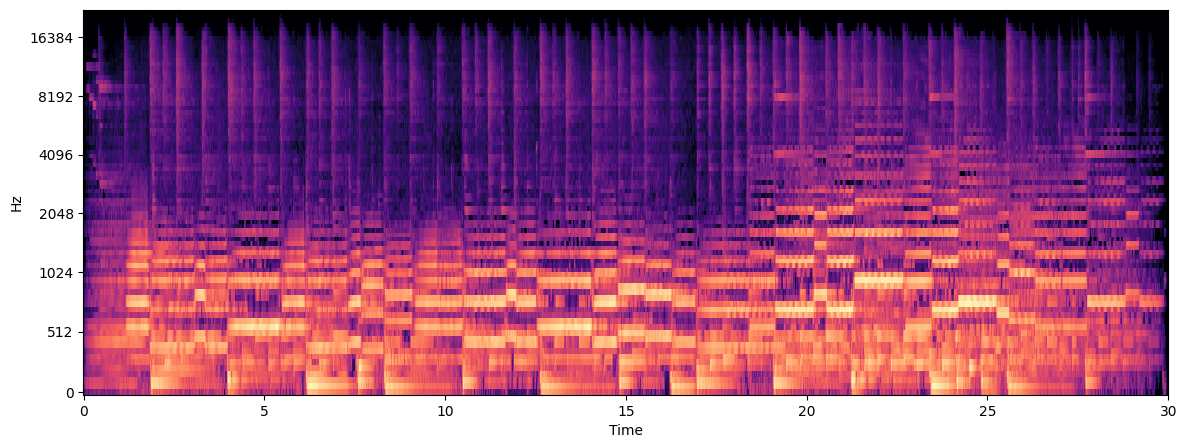

In [10]:
audio, sr = librosa.load(test, sr=sample_rate)
plt.figure(figsize=(14, 5))
S_dB = librosa.power_to_db(mel.T.numpy(), ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = spec["n_fft"], hop_length=spec["hop_size"])
Audio(audio, rate=sr)


In [11]:
mel = mel.unsqueeze(0).unsqueeze(0)
mel.shape

torch.Size([1, 1, 3001, 81])

In [14]:
with torch.no_grad():
    preds = model(mel)
    beat_preds, downbeat_preds = preds.split(1, dim=1)
beat_times = beat_dbn(beat_preds.cpu().view(-1))
downbeat_times = downbeat_dbn(downbeat_preds.cpu().view(-1))

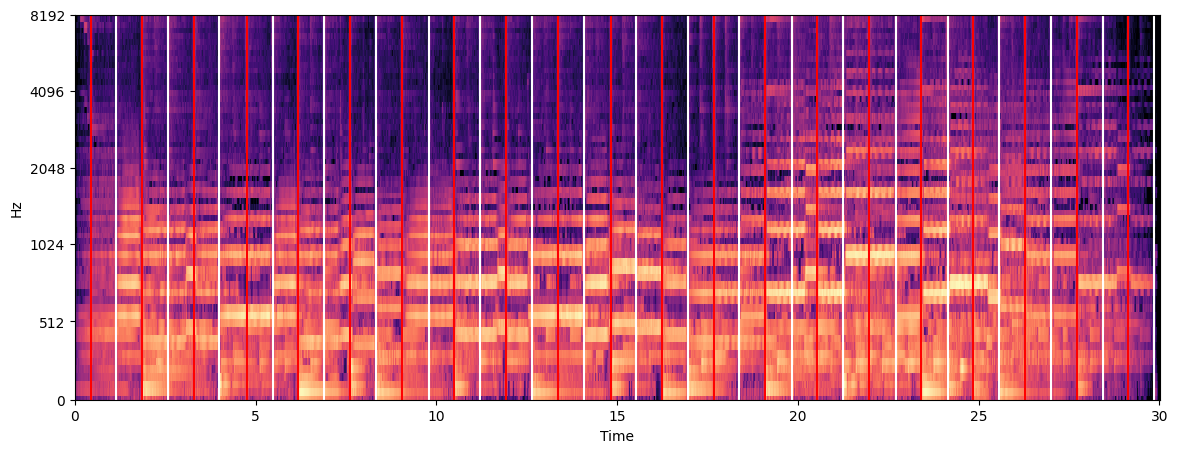

In [15]:
play_clicks = True
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = spec["n_fft"], hop_length=spec["hop_size"])
plt.vlines(beat_times, 0, 8192, color='w')
plt.vlines(downbeat_times, 0, 8192, color='r')
plt.ylim(0, 8192)

clicks = librosa.clicks(times = beat_times, sr=sr, length=len(audio))
output = audio
if play_clicks:
    output = audio + clicks
Audio(output, rate=sr)